# 「標準ベイズ統計学」の勉強メモ

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, beta
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino sans"

## 3.1 二項分布
- 同時確率密度関数と共役な分布として、パラメータθの事前分布はベータ分布が考えられる
- なのでパラメータθの事後分布はベータ分布になる
- Y=1となる確率を予測したい場合、事後分布の期待値を求める事になる

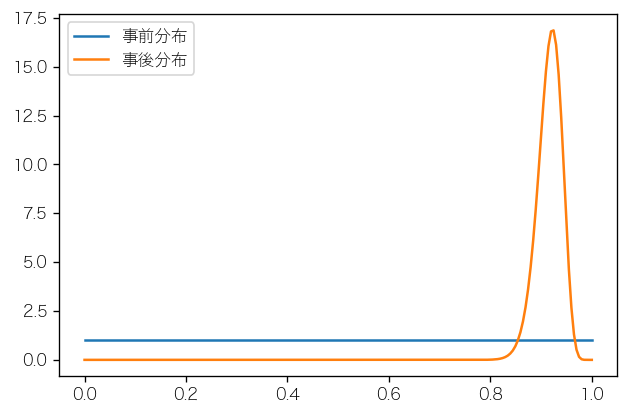

観測データの回答率0.9224806201550387
幸福と回答する確率：0.916030534351145
幸福と回答する確率の95%信用区間[0.86308488 0.95700201]


In [13]:
# 幸福度データで考える
n = 129 # アンケートした人数
y_sum = 119 # 幸福と回答した人の数

# 事前分布としてa=1、b=1のベータ分布(一様分布)を考える
a = 1
b = 1

# 事後分布のベータ分布のパラメータは以下になることが知られている
a_posterior = a+y_sum
b_posterior = b+n-y_sum
beta_dist_pre = beta(a, b)
beta_dist_pos = beta(a_posterior, b_posterior)
ls = np.linspace(0, 1, 200)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax.plot(ls, beta_dist_pre.pdf(ls), label="事前分布")
ax.plot(ls, beta_dist_pos.pdf(ls), label="事後分布")
plt.legend()
plt.show()

# 予測
print(f"観測データの回答率{y_sum/n}")
# 観測データを踏まえて、Y=1となる確率
print(f"幸福と回答する確率：{beta_dist_pos.mean()}")
print(f"幸福と回答する確率の95%信用区間{beta_dist_pos.ppf([0.025, 0.975])}")

## 3.2 ポアソンモデル
確率変数Yの予測モデルがポアソン分布と考えられるとき
- 同時確率密度関数P(y1..yn|θ)はパラメータθの元で各確率変数の確率密度の積で表される
- 同時確率密度関数と共役な分布として、パラメータθの事前分布はガンマ分布が考えられる
- なので事後分布はガンマ分布になる
- 予測分布p(y~ | y1..yn)は負の二項分布に従う

大卒の事後分布の95%信用区間[1.70494315 2.22267902]
非大卒の事後分布の95%信用区間[1.17343691 1.89083626]


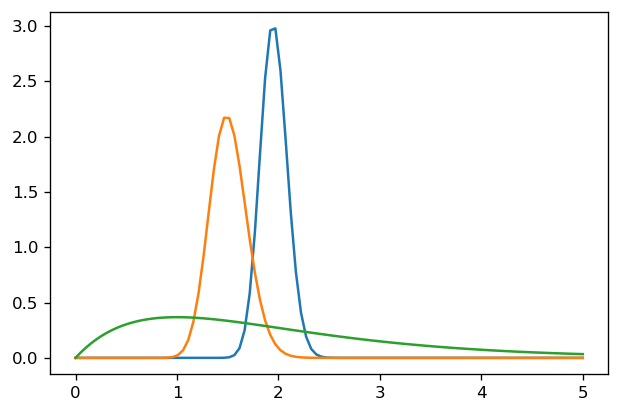

In [32]:
#ガンマ分布(事前分布)のパラメータを決定
a = 2
b = 1

# サンプルデータの定義
n1 = 111 # 大卒で子供を持っている人の数
sy1 = 217 # 大卒の人の数
n2 = 44 # 非大卒で子供を持っている人の数
sy2 = 66 # 非大卒の人の数

# 大卒の事後分布
a1_posterior = a+sy1
b1_posterior = b+n1
mu_posterior = a1_posterior / b1_posterior # 事後分布の期待値はこうなる
gamma_dist1 = gamma(a1_posterior, scale=1/b1_posterior)
print(f"大卒の事後分布の95%信用区間{gamma_dist1.ppf([0.025, 0.975])}")

# 非大卒の事後分布
a2_posterior = a+sy2
b2_posterior = b+n2
mu_posterior = a2_posterior / b2_posterior # 事後分布の期待値はこうなる
gamma_dist2 = gamma(a2_posterior, scale=1/b2_posterior)
print(f"非大卒の事後分布の95%信用区間{gamma_dist2.ppf([0.025, 0.975])}")

ls = np.linspace(0, 5, 100)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax.plot(ls, gamma_dist1.pdf(ls))
ax.plot(ls, gamma_dist2.pdf(ls))
ax.plot(ls, gamma(a, scale=1/b).pdf(ls))
plt.show()

## 7.5欠測データの観測

In [78]:
with open("../data/diabetes_200_miss.dat.txt") as f:
    data = f.readlines()
data = [d[:-1].split() for d in data]
df = pd.DataFrame(data, columns=["glu", "bp", "skin", "bmi"]).drop(0).replace("NA", np.nan)
df.head()

,glu,bp,skin,bmi
1,86.0,68.0,28.0,30.2
2,195.0,70.0,33.0,NaN
3,77.0,82.0,NaN,35.8
4,NaN,76.0,43.0,47.9
5,107.0,60.0,NaN,NaN


In [79]:
# 事前分布のパラメータ
n = df.shape[0]
p = df.shape[1]

mu0 = np.array([120, 64, 26, 26]) # 事前平均
sd0 = mu0 / 2

L0 = np.ones((p, p)) * 0.1
for i in range(len(L0)):
    L0[i][i] = 1
L0 = np.outer(sd0, sd0) * L0
nu0 = p+2
S0 = L0

# 初期値
sigma = S0
Y_full = df.copy()
O = Y_full.isna().to_numpy() * 1
